# Machine Learning in Network Science
Final Project

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- supervised link prediction using Logistic Regression, SVM, Random Forest & Boosting

### 1. Import Packages

In [43]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from '/Users/macbookpro/Documents/GitHub/Network-Science_Final-Project/util/autoencoder.py'>

In [ ]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [2]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

# hyperparameter tuning
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial
from ray.tune.sklearn import TuneSearchCV
import hyperopt

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import PredefinedSplit, ShuffleSplit

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [4]:
# might take up to a minute
(G, G_train, G_trainval, node_info, train_tf, val_tf, trainval_tf, test_tf, 
 X_train, y_train, X_val, y_val, X_trainval, 
 y_trainval, X_test, y_test) = loadData.load_transform(val_ratio = 0.2, test_ratio = 0.1, n2v_train=True)

Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Number of non-existing edges generated: 29971
Number of negative edges for training: 3802
Number of negative edges for validation: 1085
Number of negative edges for test: 542


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Enriching train data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

Enriching validation data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

Enriching test data...


c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:99: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist)
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c:\Users\pbedi\Documents\GitHub\Network-Science_Final-Project\util\preprocess_Data.py:153: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist = nodelist).toarray()
c

In [5]:
# might take up to a minute
data, _ = autoenc.load(val_ratio = 0.2, test_ratio = 0.1)

Number of positive edges for training: 3802
Number of positive edges for validation: 1085
Number of positive edges for test: 542
Number of edges in original graph: 5429
Number of edges in training graph: 3802
Number of non-existing edges generated: 29971
Number of negative edges for training: 3802
Number of negative edges for validation: 1085
Number of negative edges for test: 542
Enriching node features...


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]
c:\Users\pbedi\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
Generating walks (CPU: 1): 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]
c:\Users\pbedi\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Create PyTorch Geometric dataset...


In [6]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"/models/VGNAE_0.001_0_4982a_00000_autoencoder.pt"

model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 5, 0.2, 0.01))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.source, df_.target)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test, y_test    = loadData.split_frame(test_tf)

# merge to get trainval data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

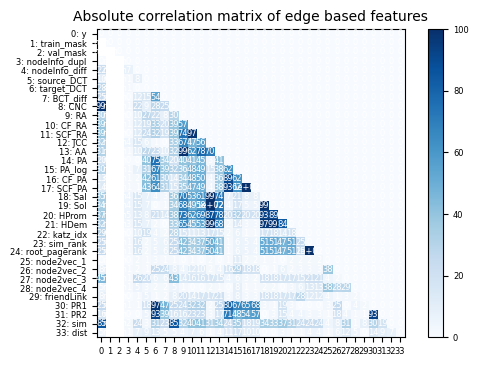

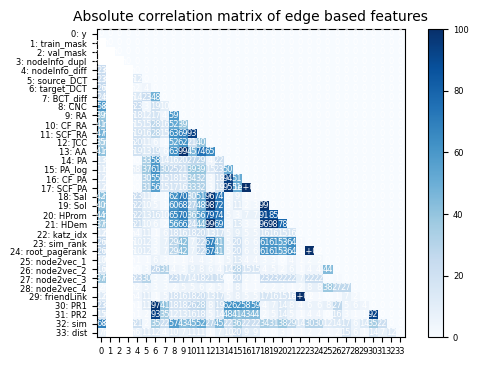

In [9]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

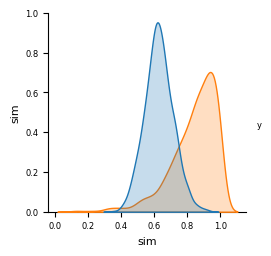

In [10]:
sns.pairplot(val_tf[["sim", "y"]], hue = "y")

### 3. Supervised Link Prediction

In [7]:
# prepare datasets for supervised methods, removing features highly correlated with target in train set but not in val set
cols = ['source_DCT', 'target_DCT', 'BCT_diff', 'katz_idx', 'node2vec_1', 'node2vec_2', 'node2vec_3', 'node2vec_4',
       'friendLink', 'PR1', 'PR2', 'sim', 'dist']
X_trainval_sv  =  X_trainval[[col for col in X_trainval.columns  if col in cols]]
X_train_sv  =  X_train[[col for col in X_train.columns  if col in cols]]
X_val_sv  =  X_val[[col for col in X_val.columns  if col in cols]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col in cols]]

# preparing predifined cv split for sklearn
val_fold = [0 if i in X_val_sv.index else -1 for i in X_trainval_sv.index]
ps = PredefinedSplit(val_fold)
ps.get_n_splits()

1

In [12]:
print(len(X_trainval_sv))
print(len(y_trainval))

9774
9774


##### a) Logistic Regression

In [13]:
# logistic regression

clf = LogisticRegressionCV(max_iter = 10000, cv = ps)
clf.fit(X_trainval_sv, y_trainval)

# predict val
y_trainval_hat = clf.predict(X_trainval_sv)
# compute accuracy
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# predict val
y_val_hat = clf.predict(X_val_sv)
y_test_hat = clf.predict(X_test_sv)
# compute accuracy
acc_val = accuracy_score(y_val, y_val_hat)
acc_test = accuracy_score(y_test, y_test_hat)
# print performance
print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")
print(f"Acc test: {acc_test}")

Acc train: 0.9329854716595049
Acc val: 0.864516129032258
Acc test: 0.8597785977859779


##### b) Random Forest & XGBoost

In [8]:
# search spaces
rdForest_params = {
                "n_estimators": tune.randint(2, 10),
                "max_depth": tune.randint(1, 3),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.2, 1),
                "bootstrap": tune.choice([True, False])
            }

XGBoost_params = {
                "n_estimators": tune.randint(2, 10),
                "max_depth": tune.randint(1, 3),
                "min_child_weight": tune.uniform(1, 10),
                "colsample_bytree": tune.uniform(0.5, 1),
                "subsample": tune.uniform(0.2, 1),
                "eta": tune.loguniform(1e-4, 1e-1)
            }

# loading models
rdForest_mdl = RandomForestClassifier()
XGBoost_mdl = XGBClassifier()

In [ ]:
# tuning RandomForestClassifier
tune_search = TuneSearchCV(
    rdForest_mdl,
    rdForest_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=ps,
    scoring='accuracy', 
    early_stopping=False,
    verbose=1,
    return_train_score=True,
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.best_estimator_.predict(X_trainval_sv)
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# performance on val set
y_val_hat = tune_search.best_estimator_.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")

In [ ]:
# tuning XGBoostClassifier
tune_search = TuneSearchCV(
    XGBoost_mdl,
    XGBoost_params,
    search_optimization="hyperopt",
    n_trials=20,
    cv=ps,
    scoring='accuracy',
    early_stopping=False,
    verbose=1,
    return_train_score=True,
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.best_estimator_.predict(X_trainval_sv)
acc_trainval = accuracy_score(y_trainval, y_trainval_hat)

# performance on val set
y_val_hat = tune_search.best_estimator_.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_trainval}")
print(f"Acc val: {acc_val}")

##### c) SVM

In [10]:
# prepare datasets for SVM
cols = ['node2vec_1', 'node2vec_2', 'node2vec_3', 'node2vec_4']
X_trainval_sv  =  X_trainval[[col for col in X_trainval.columns  if col in cols]]
X_train_sv  =  X_train[[col for col in X_train.columns  if col in cols]]
X_val_sv  =  X_val[[col for col in X_val.columns  if col in cols]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col in cols]]

In [11]:
# prepare SVM pipeline
clf = make_pipeline(StandardScaler(), SVC(C=0.001))
clf.fit(X_train_sv, y_train)

# performance on train set
y_train_hat = clf.predict(X_train_sv)
acc_train = accuracy_score(y_train, y_train_hat)

# performance on val set
y_val_hat = clf.predict(X_val_sv)
acc_val = accuracy_score(y_val, y_val_hat)

print(f"Acc train: {acc_train}")
print(f"Acc val: {acc_val}")


Acc train: 0.7006838506049448
Acc val: 0.6953917050691244
